In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import seaborn as sns
import time


import torch
import torch.nn as nn
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import transforms

In [2]:
# Set dataset paths
train_dir = "/kaggle/input/ccmt-dataset-for-crop-pest-and-disease-detection/train"
valid_dir = "/kaggle/input/ccmt-dataset-for-crop-pest-and-disease-detection/valid"


# Get list of classes (subdirectories in the 'train' directory)
classes = os.listdir(train_dir)
print(f"Classes found: {classes}")
print(f"Number of classes: {len(classes)}")

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

Classes found: ['Tomato__septoria_leaf_spot', 'Cashew__healthy', 'Tomato__healthy', 'Corn_(maize)__streak_virus', 'Corn_(maize)__leaf_beetle', 'Cassava__brown_spot', 'Tomato__leaf_blight', 'Cashew__leaf_miner', 'Corn_(maize)__leaf_blight', 'Cashew__gumosis', 'Corn_(maize)__leaf_spot', 'Tomato__verticulium_wilt', 'Cassava__green_mite', 'Cassava__healthy', 'Cassava__mosaic', 'Cashew__red_rust', 'Corn_(maize)__healthy', 'Corn_(maize)__grasshoper', 'Tomato__leaf_curl', 'Cassava__bacterial_blight', 'Cashew__anthracnose', 'Corn_(maize)__fall_armyworm']
Number of classes: 22


In [3]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

# Custom function to apply Gaussian blur and sharpening
def apply_filters(image):
    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Apply Gaussian filtering
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Convert back to PIL format
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image

# Update transformations with the custom filter function
train_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),                   # Apply custom filters
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),                   # Apply custom filters
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
# Define the training and validation datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = ImageFolder(root=valid_dir, transform=valid_transforms)

# Update data loaders with optimal settings
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:

# Parameters to test
batch_sizes = [32]
# num_workers_options = [0, 2, 4, 8]
num_workers_options = [4]

# Test each combination
results = []
for batch_size in batch_sizes:
    for num_workers in num_workers_options:
        # Define data loader with current settings
        # loader = DataLoader(train_dir, batch_size=batch_size, num_workers=num_workers)
        loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)


        # Measure loading time for a small number of batches (e.g., 10)
        start_time = time.time()
        for i, (images, labels) in enumerate(loader):
            if i >= 10:  # Only load 10 batches to test speed
                break
        end_time = time.time()

        # Record the result
        time_taken = end_time - start_time
        results.append((batch_size, num_workers, time_taken))
        print(f"Batch size: {batch_size}, Num workers: {num_workers} -> Time: {time_taken:.4f} seconds")

# Find the best configuration
best_config = min(results, key=lambda x: x[2])
print(f"\nOptimal configuration - Batch size: {best_config[0]}, Num workers: {best_config[1]}, Time: {best_config[2]:.4f} seconds")


Batch size: 32, Num workers: 4 -> Time: 2.8404 seconds

Optimal configuration - Batch size: 32, Num workers: 4, Time: 2.8404 seconds


In [7]:
# Function to get predictions and labels for a model
def get_predictions_labels(model, data_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, model_name, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(16, 14))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest", cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name} Model")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()



In [9]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained DenseNet201 model
model_densenet = models.densenet201(pretrained=True)

# Modify the final layer for 38 classes
num_features = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_features, 38)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet = model_densenet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 203MB/s]


In [16]:
# Define loss function and optimizer for densenet50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_densenet.parameters(), lr=0.001, weight_decay=0.0001,momentum=0.9)


# Early stopping parameters
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    model_densenet.train()  # Set model to training mode
    train_loss, correct, total = 0, 0, 0

    if epoch == 8:  
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1  # Reduce LR by 10x
        print(f"Learning Rate Reduced at Epoch {epoch+1} ")

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()                # Clear gradients
        outputs = model_densenet(inputs)        # Forward pass
        loss = criterion(outputs, labels)    # Compute loss
        loss.backward()                      # Backpropagation
        optimizer.step()                     # Update weights

        # Calculate training accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model_densenet.eval()  # Set model to evaluation mode
    valid_loss, correct, total = 0, 0, 0
    with torch.no_grad():  # No gradient tracking
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_densenet(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_accuracy = 100 * correct / total
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%\n")

    # Early stopping logic
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        early_stop_counter = 0
        torch.save(model_densenet.state_dict(), 'Best-Densenet201-from-scratch-with-New-Plant-Disease.pth')  # Save the best model
    # else:
    #     early_stop_counter += 1
    #     if early_stop_counter >= patience:
    #         print("Early stopping triggered")
    #         break

Epoch [1/12], Loss: 760.6818, Accuracy: 89.04%
Validation Loss: 190.7612, Validation Accuracy: 91.31%

Epoch [2/12], Loss: 562.1138, Accuracy: 91.86%
Validation Loss: 150.4398, Validation Accuracy: 93.45%

Epoch [3/12], Loss: 426.3874, Accuracy: 93.94%
Validation Loss: 131.4694, Validation Accuracy: 94.45%

Epoch [4/12], Loss: 347.5691, Accuracy: 95.09%
Validation Loss: 118.6205, Validation Accuracy: 94.99%

Epoch [5/12], Loss: 287.6402, Accuracy: 95.96%
Validation Loss: 107.4140, Validation Accuracy: 95.44%

Epoch [6/12], Loss: 234.6443, Accuracy: 96.64%
Validation Loss: 116.1021, Validation Accuracy: 95.18%

Epoch [7/12], Loss: 202.6863, Accuracy: 97.13%
Validation Loss: 109.5493, Validation Accuracy: 95.61%

Epoch [8/12], Loss: 175.3733, Accuracy: 97.52%
Validation Loss: 105.7587, Validation Accuracy: 95.99%

Learning Rate Reduced at Epoch 9 
Epoch [9/12], Loss: 111.2502, Accuracy: 98.49%
Validation Loss: 94.9264, Validation Accuracy: 96.35%

Epoch [10/12], Loss: 92.3173, Accuracy: 

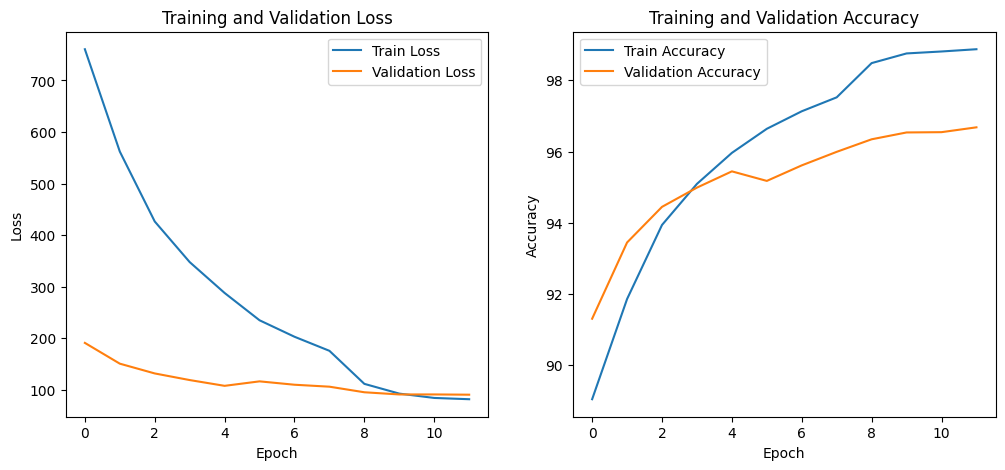

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [18]:
# Save the model state dictionary
torch.save(model_densenet.state_dict(), 'Densenet201-from-scratch-with-New-Plant-Disease.pth')

In [19]:
# Import necessary libraries
import torch
from torchvision import models
import torch.nn as nn

# Load the densenet201 model architecture 
model_densenet = models.densenet201(weights=None)  

# Modify the final layer to match the number of classes
num_features = model_densenet.classifier.in_features  
model_densenet.classifier = nn.Linear(num_features, 38)

# Load the saved state dictionary
model_densenet.load_state_dict(torch.load('Densenet201-from-scratch-with-New-Plant-Disease.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet = model_densenet.to(device)
model_densenet.eval()  # Set the model to evaluation mode


<ipython-input-19-ef7efe6d0e59>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_densenet.load_state_dict(torch.load('Densenet201-from-scratch-with-New-Plant-Disease.

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
from torchvision import models
import torch.nn as nn
from sklearn.metrics import classification_report

# DenseNet201
model_densenet201 = models.densenet201(pretrained=False)
# DenseNet models use 'classifier' instead of 'fc'
model_densenet201.classifier = nn.Linear(model_densenet201.classifier.in_features, 38)
model_densenet201.load_state_dict(torch.load('Densenet201-from-scratch-with-New-Plant-Disease.pth'))
model_densenet201 = model_densenet201.to(device)
model_densenet201.eval()

densenet201_preds, densenet201_labels = get_predictions_labels(model_densenet201, valid_loader)

print("Classification Report for DenseNet201 Model:\n")
print(classification_report(densenet201_labels, densenet201_preds))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-20-7b2ab5f0dece>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Classification Report for DenseNet201 Model:

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1838
           1       1.00      1.00      1.00       425
           2       0.97      0.99      0.98      1336
           3       0.96      0.95      0.96      1487
           4       0.99      0.99      0.99      1815
           5       0.96      0.99      0.97      2623
           6       0.98      0.95      0.97      1483
           7       0.96      0.97      0.97      1020
           8       1.00      0.98      0.99      1184
           9       0.99      0.97      0.98      1200
          10       0.98      0.99      0.99       284
          11       1.00      1.00      1.00       411
          12       0.91      0.97      0.94       211
          13       0.99      1.00      1.00       950
          14       0.84      0.94      0.89      1004
          15       0.94      0.82      0.88      1261
          16       0.95      0.98  

In [ ]:
# Class names (replace with actual class names if you have them)
class_names = [f"Class {i}" for i in range(38)]  # Replace with actual class names if available
# Plot confusion matrix for densenet50
plot_confusion_matrix(densenet201_labels, densenet201_preds, "densenet201", class_names)